In [1]:
import os
import scvi
import scgen
import rpy2
import scib
import json
import torch
import scipy
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import liana as li
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import cell2cell as c2c
import plotnine as p9
import scrublet as scr
import doubletdetection
import decoupler as dc
from rpy2.robjects import r
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from liana.method import cellphonedb
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be r

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [14]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
    library(magrittr) # needs to be run every time you start R and want to use %>%
})


In [4]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                                     22.0.0
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
adjustText                                  NA
anndata2ri                                  1.1
annoy                                       NA
appnope                                     0.1.2
asttokens                                   NA
astunparse                                  1.6.3
attr                                        21.4.0
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
boto3                                       1.26.32
botocore                                    1.29.32
bottleneck                                  1.3.5
brotli                                      NA
cell2cell                                   0.6.6
certifi               

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Cell-Cell Communication</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
adata_annot = sc.read_h5ad('../data/processed/adata_annotated.h5ad')
adata_annot = adata_annot[~adata_annot.obs.cell_type.isin(['Endothelial'])]
adata_annot.X = adata_annot.layers['counts'].toarray().copy()

In [6]:
#adata_annot = adata_annot[:, adata_annot.var.highly_variable=="True"]
adata_annot

View of AnnData object with n_obs × n_vars = 65297 × 16590
    obs: 'projid', 'fastq', 'Subject', 'sample', 'libraryid', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louvain', 'louvain_0.5_colors', 'louvain_1.0_colors', 'msex_x_colors'

In [7]:
# adata_cond = {}
# adata_cond['stim'] = adata_annot[adata_annot.obs["pathology.group"].isin(['early-pathology', 'late-pathology'])].copy()
# adata_cond['ctrl'] = adata_annot[adata_annot.obs["pathology.group"].isin(['no-pathology'])].copy()

# del adata_annot

# 2 **Modelling differential intercellular signalling with NicheNet**

## `NicheNet is another type of CCC method that considers the intracellular signaling effects triggered by intercellular interactions.`


**Summary**:

- In short, `NicheNet` infers associations between ligands and the downstream targets that they potentially modulate [**Browaeys et al., 2020**](http://www.nature.com/articles/s41592-019-0667-5). 

- Or in other words, `NicheNet` assumes that a certain sender/source cell type produces a ligand, and the binding of that ligand to a specific receiver/target cell type(s) leads to a signal propagation that affects master gene regulators, or transcription factors, and subsequently their targets. 

- `Therefore, predictions on which target genes are modulated by which ligand-receptor pairs may provide interesting hypotheses concerning the ongoing CCC events`. 

- Furthermore, enrichment of target genes of a specific ligand-receptor pair in a receiver cell type can also indicate that this ligand-receptor pair is functionally active. 

- In summary, a NicheNet analysis can thus be performed to 

    - Infer potential target genes of expressed ligand-receptor interactions and

    - Prioritize ligand-receptor interactions based on their target gene enrichment in the receiver. `This enrichment is called “ligand activity"`, in analogy to transcription factor activity, Gene set enrichment, and pathway analysis.

## 2.2 **Motivation**

From the differential pathway analysis, we observe that certain pathways that are specific to some cell-types are instead differentially perturbed in other cell-types. This could be arise from cell autonomous processes or from more complex mechanisms involving paracrine signalling from other cell types. To accurately delineate this, we perform cell-cell communication analysis in this study using the procedures described in [**Single-cell Best Practices**](https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html)

## 2.3. **Methods**


**What**

- To perform these tasks, `NicheNet makes use of prior knowledge about ligand-target associations.`

- However, contrary to ligand-receptor databases, comprehensive ligand-target databases do not exist. Therefore, `NicheNet predicts ligand-target associations by integrating three layers of prior knowledge covering ligand-receptor, intracellular signaling, and gene regulatory interactions.` 

- `Using these three layers of information, NicheNet calculates a regulatory potential score for each ligand-target link`. 

- `This regulatory potential denotes how well prior knowledge supports that a ligand may regulate the expression of a target gene. T

**How**

- To calculate regulatory potential, NicheNet first employs a network diffusion algorithm, known as Personalized PageRank (PPR), on the integrated signaling network to estimate the probability that a given ligand may signal to a particular regulator.

- Specifically, the PPR implementation in NicheNet considers a given ligand as the seed node of interest. Hereby, nodes that are closer to the ligand in the signaling network get higher scores than more distant nodes under the assumption that regulators in the network vicinity of the ligand are more likely modulated by the ligand than more distant nodes.

- The application of PPR for all ligands in the database thus results in a ligand-regulator matrix of signalling probabilities that are then multiplied with a weight matrix of regulators to target genes in order to obtain ligand-target regulatory potential scores [**Browaeys et al., 2020**](http://www.nature.com/articles/s41592-019-0667-5). 

- Conceptually, this implies that a ligand–target pair receives a high regulatory potential score if the ligand can signal to regulators of that target gene. These prior knowledge-derived scores are then used in conjunction with the expression data of interacting cells to prioritize ligand-receptor interactions and predict their target genes.



#### **Implementation**

Because NicheNet focuses on how ligands affect gene expression in potentially interacting cells, one needs to be able to define which gene expression changes may (partially) be caused by CCC processes. To rank the ligands according to their potential ligand activity in a receiver cell type, it requires a set of genes assumed to be affected by CCC events in the receiver cell types. The authors of NicheNet recommend ideally defining those sets of genes when working with conditions, e.g. treatment vs control. To this end, we will apply NicheNet in exactly that manner and compare the expression of the patients in our data before and after stimulation with INF-beta.


## **Load NicheNet Prior-Knowledge**

As mentioned above, NicheNet requires prior knowledge about ligand-receptor interactions and ligand-target links:

a `ligand_target_matrix` - denotes the potential that a ligand might regulate the expression of a target genes. The weights in this matrix are based on prior knowledge and are required to prioritize possible ligand-receptor interactions and affected target genes.

`lr_network` - the database of ligand-receptor interactions needed to define expressed ligands, receptors and their interactions.

We will load each of those from Zenodo DOI (this might take a couple of minutes).

In [8]:
%%R
# load NicheNet (NicheNet is only available on GitHub)
suppressPackageStartupMessages({
    if(!require(nichenetr)) remotes::install_github("saeyslab/nichenetr", upgrade = "never")
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [9]:
%%R
# Increase timeout threshold
options(timeout=600)

# Load PK
ligand_target_matrix <- readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"))
lr_network <- readRDS(url("https://zenodo.org/record/7074291/files/lr_network_human_21122021.rds"))

### **Step 1. Define cell types of interest to be considered as senders/sources and receiver/targets of CCC interactions**

In [10]:
sender_celltypes = ["Microglia", "Astrocyte", "Oligodendrocyte"]
receiver_celltypes = ["Excitatory"]

### **Step 2. Define a set of ligands that can potentially affect receiver cell types**

Similarly to the ligand-receptor method, here we are only interested in the potential interactions that involve sufficiently expressed genes in each cell type. So, we will assume that e.g. 10% of the cells is a good threshold to reflect genes as expressed within a cell type.

In [11]:
# Helper function to obtain sufficiently expressed genes
from functools import reduce


def get_expressed_genes(adata, cell_type, expr_prop):
    # calculate proportions
    temp = adata[adata.obs["cell_type"] == cell_type, :]
    a = np.count_nonzero(temp.X, axis=0) / temp.X.shape[0]
    stats = (
        pd.DataFrame({"genes": temp.var_names, "props": a})
        .assign(cell_type=cell_type)
        .sort_values("genes")
    )

    # obtain expressed genes
    stats = stats[stats["props"] >= expr_prop]
    expressed_genes = stats["genes"].values

    return expressed_genes

In [12]:
sender_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_annot, cell_type=cell_type, expr_prop=0.1)
        for cell_type in sender_celltypes
    ],
)
receiver_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_annot, cell_type=cell_type, expr_prop=0.1)
        for cell_type in receiver_celltypes
    ],
)

**Then use this information to keep only ligand-receptor pairs in the NicheNet network that are expressed**

In [15]:
%%R -i sender_expressed -i receiver_expressed
# get ligands and receptors in the resource
ligands <- lr_network %>% pull(from) %>% unique()
receptors <- lr_network %>% pull(to) %>% unique()

# only keep the intersect between the resource and the data
expressed_ligands <- intersect(ligands, sender_expressed)
expressed_receptors <- intersect(receptors, receiver_expressed)

# filter the network to only include ligands for which both the ligand and receptor are expressed
potential_ligands <- lr_network %>% 
  filter(from %in% expressed_ligands & to %in% expressed_receptors) %>%
  pull(from) %>% unique()

### **Step 3. Define a gene set of interest in receiver cell type(s)**

This step is the most critical one in a NicheNet analysis. Here, one defines which genes are potentially modulated by cell-cell communication, i.e. the genes thought to be affected by ligand signalling. For example, one can assume that differentially expressed genes between conditions in receiver cell type(s) are driven by ligands from one of more interacting sender cell populations. Another example would be differentially expressed genes between a differentiated cell population and a progenitor population in case the differentiation is likely induced through interactions with other cell types.


So, we will now use `decoupler` to generate pseudobulk profiles per cell type and sample, and then perform a differential expression analysis on those. 

A crucial step of pseudo-bulking is filtering out genes that are not expressed across most cells and samples, since they are very noisy and can result in unstable log-fold changes. To get robust profiles, genes are thus filtered out if again they are not expressed sufficiently per sample (min_prop) and and in not enough samples.

In [16]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_annot,
    sample_col="Subject",
    groups_col="cell_type",
    min_prop=0.1,
    min_smpls=3,
    layer="counts",
)

**Normalize the pseudobulk counts**

In [17]:
# Storing the raw counts
pdata.layers["counts"] = pdata.X.copy()

# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)

# Normalize
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
# check how this looks like
pdata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 275 × 11218
    obs: 'projid', 'fastq', 'Subject', 'sample', 'libraryid', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'sampleid', 'predicted_doublet', 'cell_type', 'lib_size'
    uns: 'log1p'
    layers: 'counts'

**We perform a very simple differential analysis contrast. For this example we will use t-test as is implemented in scanpy but we could use any other**

In [18]:
logFCs, pvals = dc.get_contrast(
    pdata,
    group_col="cell_type",
    condition_col="pathologic diagnosis of AD",
    condition="YES",
    reference="NO",
    method="t-test",
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [19]:
logFCs

,A1BG,A2M,A2ML1,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM6,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Astrocyte,0.000000,0.000000,-0.004607,-0.160126,-0.392872,0.000000,-0.224556,-0.069535,0.100249,0.135810,...,-0.046781,-0.141039,0.380100,0.000000,0.000000,0.096585,0.280797,0.000000,-0.289247,0.123034
Excitatory,0.197113,0.000000,-0.218318,0.161319,-0.079825,-0.102118,-0.002808,0.003007,-0.045618,-0.029639,...,-0.078039,0.033049,0.232039,0.127525,0.000362,0.051107,0.136768,0.083664,-0.097624,0.002778
Inhibitory,0.000000,0.000000,0.000000,-0.016103,-0.199458,0.000000,-0.160703,-0.099418,-0.075523,-0.152813,...,0.080182,0.028080,0.111483,0.000000,0.000000,-0.160203,0.075422,-0.051560,-0.047787,-0.045154
Microglia,0.000000,0.120096,0.000000,0.000000,0.000000,0.000000,0.052435,0.205445,0.000000,0.000000,...,0.030730,-0.028728,-0.592833,0.000000,0.000000,0.000974,0.266181,0.000000,-0.570276,0.375388
OPC,0.000000,0.000000,0.000000,0.170762,-0.693136,0.147532,-0.533112,0.067349,-0.021949,-0.020762,...,-0.002076,0.181897,-0.059583,0.000000,0.000000,0.196590,-0.167947,0.000000,0.018241,0.193635
Oligodendrocyte,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.087037,-0.055034,0.200145,...,0.108725,0.219630,0.150733,0.000000,0.000000,0.082303,0.026162,0.000000,0.012623,-0.032651


Then keep only the positive significant differentially expressed genes in the receiver cell type(s)

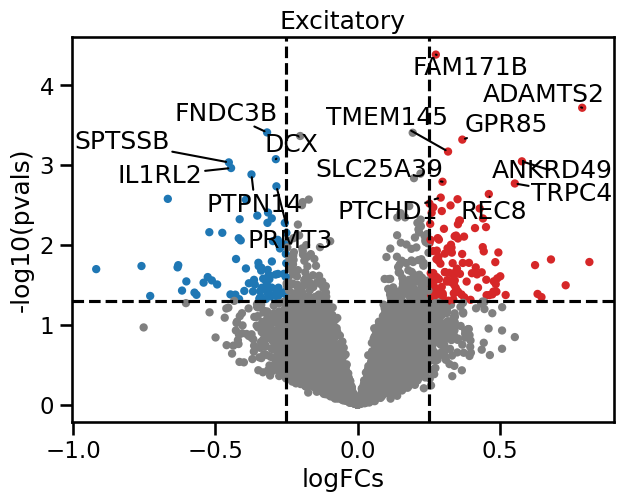

In [29]:
# Visualize those for e.g. CD14+ Monocytes
dc.plot_volcano(logFCs, pvals, "Excitatory", top=15, sign_thr=0.05, lFCs_thr=0.25)

In [30]:
# format results
deg = dc.format_contrast_results(logFCs, pvals)
# only keep the receiver cell type(s)
deg = deg[np.isin(deg["contrast"], receiver_celltypes)]
deg.head()

,contrast,name,logFCs,pvals,adj_pvals
11218,Excitatory,FAM171B,0.275533,0.000041,0.460382
11219,Excitatory,ADAMTS2,0.790262,0.000190,0.892567
11220,Excitatory,FNDC3B,-0.318049,0.000388,0.892567
11221,Excitatory,LPGAT1,0.194131,0.000392,0.892567
11222,Excitatory,ELMO1,-0.201567,0.000430,0.892567


Now that we have the DE stats for the receiver cell type, we can use those to define the background and geneset of interest for ligand activity analysis with NicheNet.

In [31]:
# define background of sufficiently expressed genes
background_genes = deg["name"].values

# only keep significant and positive DE genes
deg = deg[(deg["pvals"] <= 0.05) & (deg["logFCs"] > 0.25)]
# get geneset of interest
geneset_oi = deg["name"].values

### **Step 4. NicheNet ligand activity estimation**


To estimate ligand activity, NicheNet uses the regulatory potential of genes (based on prior knowledge) to predict which ligand best predicts the gene set of interest. Or in other words, it assesses whether the genes with high regulatory potential in regards to a specific ligand, are more likely to belong to the geneset of interest that we derive for the receiver cell type(s). Conceptually, this is not too dissimilar from standard Gene set enrichment and pathway analysis and NicheNet proposes different ways to estimate ligand activity, such as the area under the receiver operating characteristic curve, or Pearson correlation [Browaeys et al., 2020].

In [32]:
%%R -i geneset_oi -i background_genes -o ligand_activities

ligand_activities <- predict_ligand_activities(geneset = geneset_oi, 
                                               background_expressed_genes = background_genes,
                                               ligand_target_matrix = ligand_target_matrix,
                                               potential_ligands = potential_ligands)

ligand_activities <- ligand_activities %>% 
  arrange(-aupr) %>% 
  mutate(rank = rank(desc(aupr)))

# show top10 ligand activities
head(ligand_activities, n=10)

# A tibble: 10 × 6
   test_ligand auroc   aupr aupr_corrected  pearson  rank
   <chr>       <dbl>  <dbl>          <dbl>    <dbl> <dbl>
 1 ANGPTL4     0.532 0.0132       0.00238   0.0233      1
 2 LGI1        0.511 0.0130       0.00224   0.0149      2
 3 WIF1        0.501 0.0121       0.00133   0.00639     3
 4 COPA        0.501 0.0121       0.00133   0.0182      4
 5 PDGFC       0.497 0.0120       0.00118   0.0130      5
 6 DSCAM       0.519 0.0119       0.00113   0.00644     6
 7 ALCAM       0.474 0.0118       0.00103  -0.00132     7
 8 EDIL3       0.506 0.0116       0.000799  0.00298     8
 9 OMG         0.507 0.0115       0.000722  0.00453     9
10 NTM         0.512 0.0115       0.000674  0.00210    10


### **Step 5. Infer & Visualize top-predicted target genes for top ligands**

In [33]:
%%R -o vis_ligand_target
top_ligands <- ligand_activities %>%
  top_n(15, aupr) %>% 
  arrange(-aupr) %>%
  pull(test_ligand) %>%
  unique()

# get regulatory potentials
ligand_target_potential <- map(top_ligands,
                               ~get_weighted_ligand_target_links(.x,
                                                                 geneset = geneset_oi,
                                                                 ligand_target_matrix = ligand_target_matrix,
                                                                 n = 500)
                              ) %>%
    bind_rows() %>% 
    drop_na()
    
# prep for visualization
active_ligand_target_links <- 
  prepare_ligand_target_visualization(ligand_target_df = ligand_target_potential, 
                                      ligand_target_matrix = ligand_target_matrix)

# order ligands & targets
order_ligands <- intersect(top_ligands,
                           colnames(active_ligand_target_links)) %>% rev() %>% make.names()
order_targets <- ligand_target_potential$target %>%
  unique() %>% 
  intersect(rownames(active_ligand_target_links)) %>%
  make.names()
rownames(active_ligand_target_links) <- rownames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23
colnames(active_ligand_target_links) <- colnames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23

vis_ligand_target <- active_ligand_target_links[order_targets, order_ligands] %>%
  t()
    
# convert to dataframe, and then it's returned to py
vis_ligand_target <- vis_ligand_target %>%
    as.data.frame() %>%
    rownames_to_column("ligand") %>%
    as_tibble()

In [34]:
# convert dot to underscore and set ligand as index
vis_ligand_target["ligand"] = vis_ligand_target["ligand"].replace("\.", "_", regex=True)
vis_ligand_target.set_index("ligand", inplace=True)
# keep only columns where at least one gene has a regulatory potential >= 0.05
vis_ligand_target = vis_ligand_target.loc[
    :, vis_ligand_target[vis_ligand_target >= 0.05].any()
]
vis_ligand_target.head()

<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:2: DeprecationWarning: invalid escape sequence '\.'
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7440/936535599.py:2: DeprecationWarning: invalid escape sequence '\.'


,CKAP2,NEB,TDRD6,IRS1,SLC2A12,TGFBR3,ADAMTS2,B3GALT2,MNS1,PRELP,TRPC4,SESN2
ligand,,,,,,,,,,,,
ENTPD1,0.000000,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
PTN,0.000000,0.0000,0.0,0.008520,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
SPON1,0.000000,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
JAM2,0.006713,0.0069,0.0,0.013422,0.01019,0.0,0.0,0.0,0.008457,0.0,0.010124,0.009314
OMG,0.000000,0.0000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


### **Visualize top ligands & regulatory targets**

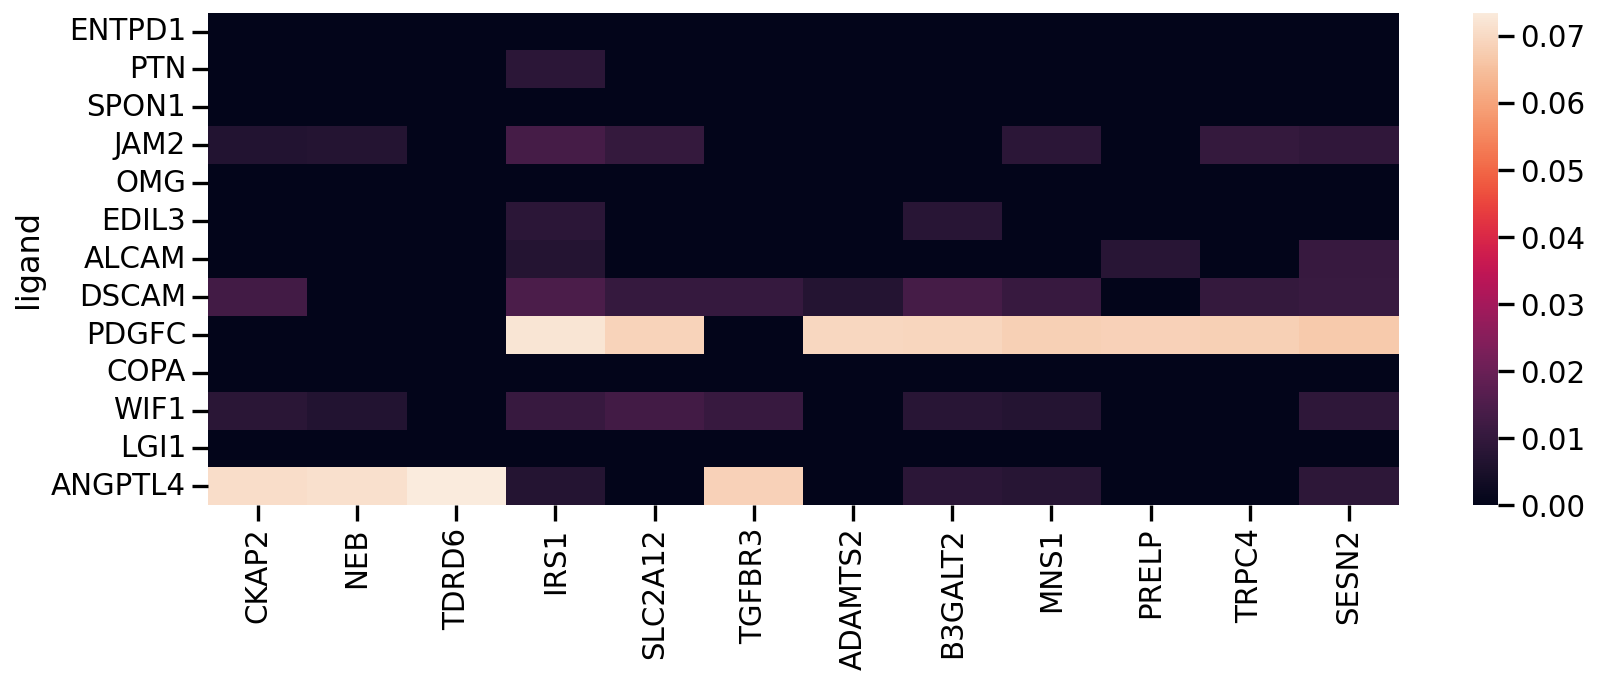

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sb.heatmap(vis_ligand_target, xticklabels=True, ax=ax)
plt.show()

Perfect, we end up with ligands that are most probable to affect downstream signalling in the receiver cell type(s), as well as their most likely targets.

## **Combining NicheNet output with ligand-receptor inference**

NicheNet and ligand-receptor methods are not exclusive, but rather complimentary, as they address different questions and in different ways. Ligand-receptor methods, such as the ones that we show above, infer ligand-receptor interactions using the expression of interacting ligands and receptors, and typically work on “steady-state” data. 

On the contrary, NicheNet predicts which of these inferred ligand-receptor links are possibly the most functional based on gene expression changes that are induced in the target cell type(s), in a process largely dependent on prior knowledge alone. Thus, while the choice of tool depends on the research question, one could also see ligand-receptor (e.g. CellPhoneDB or LIANA) methods and intracellular signalling CCC methods (e.g. NicheNet) as complementary.

For example, given the top 3 prioritized ligands, we can focus on ligand-receptor pairs that include those and the receiver cell type that we used to infer the active ligands.

So, let’s see which ligand-receptor interactions that involve the top 5 potentially active ligands from NicheNet were prioritized as consistently relevant by the different methods in LIANA:



In [36]:
ligand_oi = ligand_activities.head(3)["test_ligand"].values

In [37]:
ligand_oi

array(['ANGPTL4', 'LGI1', 'WIF1'], dtype=object)

In [ ]:
li.pl.dotplot(
    adata=adata_stim,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=sender_celltypes,
    target_labels=receiver_celltypes,
    # keep only those ligands
    filterby="ligand_complex",
    filter_lambda=lambda x: np.isin(x, ligand_oi),
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="magnitude_rank",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=25,  # and we want to keep only the top 25 interactions
    figure_size=(9, 9),
    size_range=(1, 6),
)